In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from matplotlib.patches import Rectangle

def simulate_qc(time_array, y_road, ms, mu, kt, k, b, c):
    ys = np.zeros_like(time_array)
    yu = np.zeros_like(time_array)
    vs = np.zeros_like(time_array)
    vu = np.zeros_like(time_array)

    for i in range(1, len(time_array)):
        delta = time_array[i] - time_array[i - 1]
        f_t = c * vs[i - 1] - c * vu[i - 1] + k * ys[i - 1] - k * yu[i - 1]
        h_t = f_t - kt * yu[i - 1] + kt * y_road[i - 1]

        ys[i] = ys[i - 1] + vs[i - 1] * delta
        yu[i] = yu[i - 1] + vu[i - 1] * delta
        vs[i] = vs[i - 1] + ((-(mu + b) * f_t + b * h_t) / (ms * mu + (ms + mu) * b)) * delta
        vu[i] = vu[i - 1] + ((-b * f_t + (ms + b) * h_t) / (ms * mu + (ms + mu) * b)) * delta

    return ys, yu, vs, vu

In [109]:
ms = 250       # The sprung mass
mu = 35        # The unsprung mass
kt = 150e3     # The spring constant for the tyre
k = 1500       # The spring constant for the suspension
b = 800       # The inertance
c = 8000       # The damping coefficient
dt = 0.001     # The time increment
time_start = 0     # Start time for simulation
time_end = 5       # End time for simulation
speed = 6      # Speed of the car in m/s

# Create a time array
time_array = np.arange(time_start, time_end, dt)

In [110]:
def good_road_profile(time_array, speed):
    length = len(time_array)
    y_road = np.zeros(length)
    bump_interval = int(100 * speed) 
    bump_width = int(10 * speed)
    bump_height = 0.01

    for i in range(0, length//2, bump_interval):
        if (i // bump_interval) % 2 == 0: 
            y_road[i:i + bump_width] = bump_height
        else:  
            y_road[i:i + bump_width] = -bump_height

    return y_road

def bad_road_profile(time_array, speed):
    length = len(time_array)
    y_road = np.zeros(length)
    bump_interval = int(50 * speed) 
    bump_width = int(10 * speed)
    bump_height = 0.05 

    for i in range(0, length//2, bump_interval):
        if (i // bump_interval) % 2 == 0:
            y_road[i:i + bump_width] = bump_height
        else: 
            y_road[i:i + bump_width] = -bump_height

    return y_road

def pothole_road_profile(time_array, speed):
    length = len(time_array)
    y_road = np.zeros(length) 
    pothole_depth = -0.2  
    pothole_width = int(45 * speed) 

    for i in range(50, length//2, 300 * speed):  
        if i + pothole_width < length:
            y_road[i:i + pothole_width] = pothole_depth

    return y_road

def speed_bump_road_profile(time_array, speed, hump_half_width=1.2, hump_height=0.2, distance_between_humps=15):
    length = len(time_array)
    hump_radius = (hump_half_width ** 2) / (2 * hump_height)
    y_road = np.zeros_like(time_array)
    for i in range(length//2):
        val1 = (speed * time_array[i] % distance_between_humps)
        x_distance_mod = np.maximum(np.minimum(val1 - distance_between_humps / 2, hump_half_width), -hump_half_width)
        y_road[i] = hump_radius * np.cos(np.arcsin(x_distance_mod / hump_radius)) - hump_radius + hump_height

    return y_road

def uneven_road_profile(time_array):
    length = len(time_array)
    peak = length // 2
    max_height = 0.1  
    y_road = np.zeros(length)
    y_road[:peak] = np.linspace(0, max_height, peak)
    y_road[peak:] = np.linspace(max_height, 0, length - peak)

    return y_road

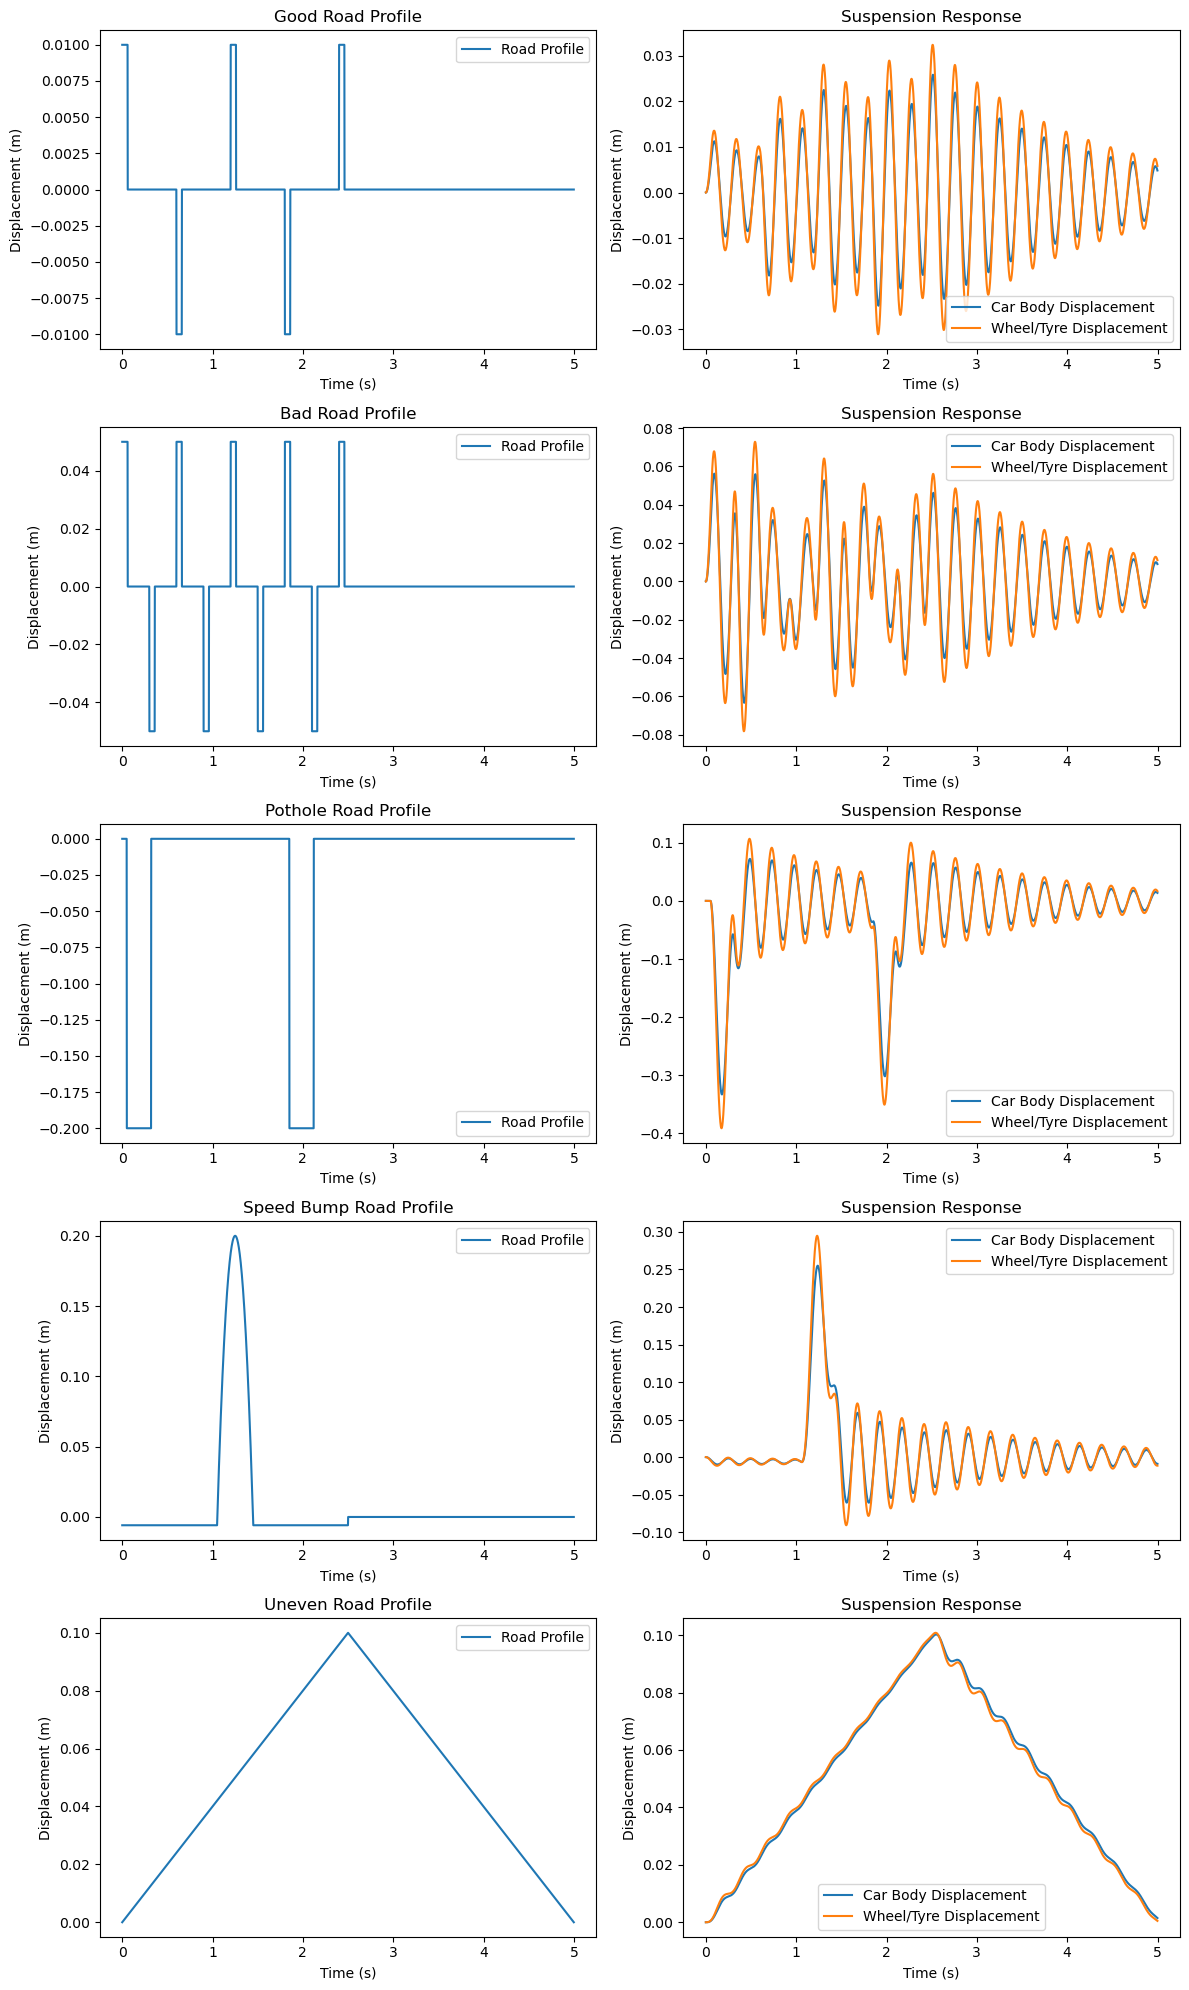

In [111]:
# Good Road Profile
y_road_good = good_road_profile(time_array, speed)
ys_good, yu_good, vs_good, vu_good = simulate_qc(time_array, y_road_good, ms, mu, kt, k, b, c)

# Bad Road Profile
y_road_bad = bad_road_profile(time_array, speed)
ys_bad, yu_bad, vs_bad, vu_bad = simulate_qc(time_array, y_road_bad, ms, mu, kt, k, b, c)

# Road with Potholes
y_road_pothole = pothole_road_profile(time_array, speed)
ys_pothole, yu_pothole, vs_pothole, vu_pothole = simulate_qc(time_array, y_road_pothole, ms, mu, kt, k, b, c)

# Speed Bump Road
y_road_speed_bump= speed_bump_road_profile(time_array, speed)
ys_speed_bump, yu_speed_bump, vs_speed_bump, vu_speed_bump = simulate_qc(time_array, y_road_speed_bump, ms, mu, kt, k, b, c)

# Uneven Road
y_road_uneven = uneven_road_profile(time_array)
ys_uneven, yu_uneven, vs_uneven, vu_uneven = simulate_qc(time_array, y_road_uneven, ms, mu, kt, k, b, c)

fig, axs = plt.subplots(5, 2, figsize=(12, 20))

# Good Road
axs[0, 0].plot(time_array, y_road_good, label='Road Profile')
axs[0, 0].set_title('Good Road Profile')
axs[0, 1].plot(time_array, ys_good, label='Car Body Displacement')
axs[0, 1].plot(time_array, yu_good, label='Wheel/Tyre Displacement')
axs[0, 1].set_title('Suspension Response')

# Bad Road
axs[1, 0].plot(time_array, y_road_bad, label='Road Profile')
axs[1, 0].set_title('Bad Road Profile')
axs[1, 1].plot(time_array, ys_bad, label='Car Body Displacement')
axs[1, 1].plot(time_array, yu_bad, label='Wheel/Tyre Displacement')
axs[1, 1].set_title('Suspension Response')

# Road with Potholes
axs[2, 0].plot(time_array, y_road_pothole, label='Road Profile')
axs[2, 0].set_title('Pothole Road Profile')
axs[2, 1].plot(time_array, ys_pothole, label='Car Body Displacement')
axs[2, 1].plot(time_array, yu_pothole, label='Wheel/Tyre Displacement')
axs[2, 1].set_title('Suspension Response')

# Speed Bump Road
axs[3, 0].plot(time_array, y_road_speed_bump, label='Road Profile')
axs[3, 0].set_title('Speed Bump Road Profile')
axs[3, 1].plot(time_array, ys_speed_bump, label='Car Body Displacement')
axs[3, 1].plot(time_array, yu_speed_bump, label='Wheel/Tyre Displacement')
axs[3, 1].set_title('Suspension Response')

# Uneven Road
axs[4, 0].plot(time_array, y_road_uneven, label='Road Profile')
axs[4, 0].set_title('Uneven Road Profile')
axs[4, 1].plot(time_array, ys_uneven, label='Car Body Displacement')
axs[4, 1].plot(time_array, yu_uneven, label='Wheel/Tyre Displacement')
axs[4, 1].set_title('Suspension Response')

for ax in axs.flat:
    ax.set(xlabel='Time (s)', ylabel='Displacement (m)')
    ax.legend()

plt.tight_layout()
plt.show()

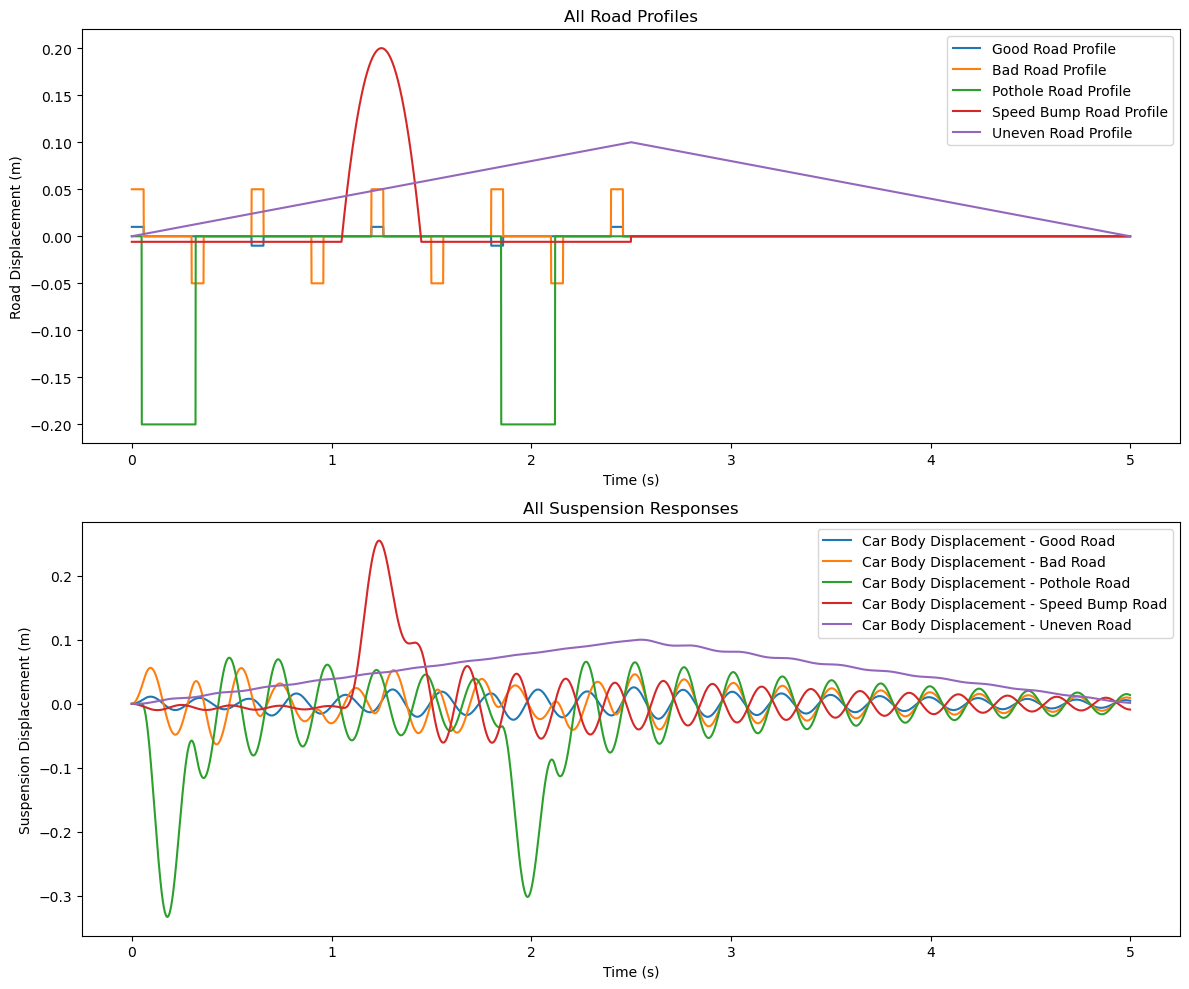

In [112]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(time_array, y_road_good, label='Good Road Profile')
axs[0].plot(time_array, y_road_bad, label='Bad Road Profile')
axs[0].plot(time_array, y_road_pothole, label='Pothole Road Profile')
axs[0].plot(time_array, y_road_speed_bump, label='Speed Bump Road Profile')
axs[0].plot(time_array, y_road_uneven, label='Uneven Road Profile')
axs[0].set_title('All Road Profiles')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Road Displacement (m)')
axs[0].legend()

axs[1].plot(time_array, ys_good, label='Car Body Displacement - Good Road')
axs[1].plot(time_array, ys_bad, label='Car Body Displacement - Bad Road')
axs[1].plot(time_array, ys_pothole, label='Car Body Displacement - Pothole Road')
axs[1].plot(time_array, ys_speed_bump, label='Car Body Displacement - Speed Bump Road')
axs[1].plot(time_array, ys_uneven, label='Car Body Displacement - Uneven Road')
axs[1].set_title('All Suspension Responses')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Suspension Displacement (m)')
axs[1].legend()

plt.tight_layout()
plt.show()

In [113]:
def calc_discomfort(vs, dt):
    acceleration = np.diff(vs) / dt
    discomfort = np.sum(acceleration**2)

    return discomfort

In [114]:
discomfort_good = calc_discomfort(vs_good, dt)
discomfort_bad = calc_discomfort(vs_bad, dt)
discomfort_pothole = calc_discomfort(vs_pothole, dt)
discomfort_speed_bump = calc_discomfort(vs_speed_bump, dt)
discomfort_uneven = calc_discomfort(vs_uneven, dt)

print("Discomfort Levels:")
print("Good Road:", discomfort_good)
print("Bad Road:", discomfort_bad)
print("Pothole Road:", discomfort_pothole)
print("Speed Bump Road:", discomfort_speed_bump)
print("Uneven Road:", discomfort_uneven)

Discomfort Levels:
Good Road: 279453.46287852956
Bad Road: 1581345.616317722
Pothole Road: 4652513.0935107935
Speed Bump Road: 1184799.7443891917
Uneven Road: 1198.4556565932783


In [115]:
def explore_qc(time_array, y_road, ms, mu, kt, k, inerter_array, damping_coefficient_array):
    discomfort_array = np.zeros((len(inerter_array), len(damping_coefficient_array)))

    for i, b in enumerate(inerter_array):
        for j, c in enumerate(damping_coefficient_array):
            ys, yu, vs, vu = simulate_qc(time_array, y_road, ms, mu, kt, k, b, c)
            discomfort = calc_discomfort(vs, np.diff(time_array)[0])
            discomfort_array[i, j] = discomfort

    return discomfort_array

In [116]:
def optimise_qc(discomfort_array, inerter_array, damping_coefficient_array, discomfort_upper_limit):
    min_index = np.unravel_index(np.argmin(discomfort_array, axis=None), discomfort_array.shape)
    min_inerter = inerter_array[min_index[0]]
    min_damping_coefficient = damping_coefficient_array[min_index[1]]

    max_discomfort_adjusted = np.where(discomfort_array <= discomfort_upper_limit, discomfort_array, -np.inf)
    max_index = np.unravel_index(np.argmax(max_discomfort_adjusted, axis=None), max_discomfort_adjusted.shape)
    max_inerter = inerter_array[max_index[0]]
    max_damping_coefficient = damping_coefficient_array[max_index[1]]

    return min_inerter, min_damping_coefficient, max_inerter, max_damping_coefficient

In [117]:
discomfort_upper_limit = 100000
inerter_values = 10       
damper_values = 20        
b_lower = 100  
b_upper = 2000  
c_lower = 500  
c_upper = 8000 

inerter_array = np.linspace(b_lower, b_upper, inerter_values)
damping_coefficient_array = np.linspace(c_lower, c_upper, damper_values)

road_profiles = {
    "Good Road": y_road_good,
    "Bad Road": y_road_bad,
    "Pothole Road": y_road_pothole,
    "Speed Bump Road": y_road_speed_bump,
    "Uneven Road": y_road_uneven
}

for road_name, y_road in road_profiles.items():
    discomfort_array = explore_qc(time_array, y_road, ms, mu, kt, k, inerter_array, damping_coefficient_array)
    
    min_inerter, min_damping_coefficient, max_inerter, max_damping_coefficient = \
        optimise_qc(discomfort_array, inerter_array, damping_coefficient_array, discomfort_upper_limit)
    
    print(f"Optimal Parameters for {road_name}:")
    print(f"Best Comfort - Inerter: {min_inerter}, Damping Coefficient: {min_damping_coefficient}")
    print(f"Worst Comfort (under limit) - Inerter: {max_inerter}, Damping Coefficient: {max_damping_coefficient}")
    print()

Optimal Parameters for Good Road:
Best Comfort - Inerter: 100.0, Damping Coefficient: 4842.105263157895
Worst Comfort (under limit) - Inerter: 522.2222222222222, Damping Coefficient: 8000.0

Optimal Parameters for Bad Road:
Best Comfort - Inerter: 100.0, Damping Coefficient: 2473.684210526316
Worst Comfort (under limit) - Inerter: 100.0, Damping Coefficient: 500.0

Optimal Parameters for Pothole Road:
Best Comfort - Inerter: 100.0, Damping Coefficient: 5236.842105263158
Worst Comfort (under limit) - Inerter: 100.0, Damping Coefficient: 500.0

Optimal Parameters for Speed Bump Road:
Best Comfort - Inerter: 100.0, Damping Coefficient: 1684.2105263157896
Worst Comfort (under limit) - Inerter: 100.0, Damping Coefficient: 894.7368421052631

Optimal Parameters for Uneven Road:
Best Comfort - Inerter: 100.0, Damping Coefficient: 2473.684210526316
Worst Comfort (under limit) - Inerter: 2000.0, Damping Coefficient: 500.0



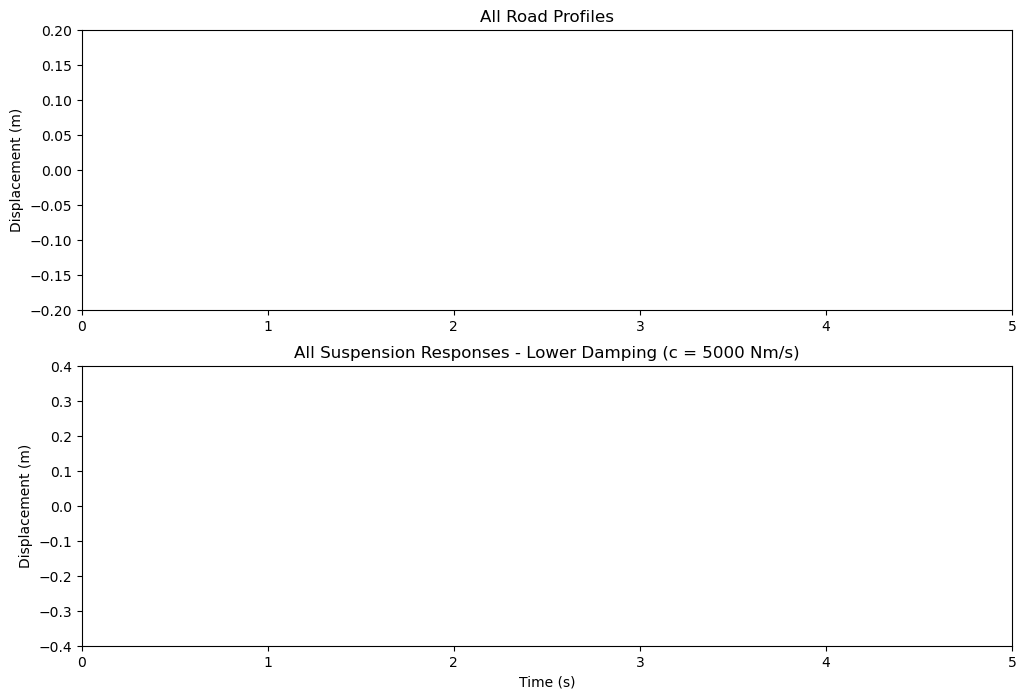

In [107]:
f_y_road_good = interp1d(time_array, y_road_good, kind='cubic')
f_ys_good = interp1d(time_array, ys_good, kind='cubic')
f_yu_good = interp1d(time_array, yu_good, kind='cubic')

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_ylim(-.2, .2)
axs[1].set_ylim(-.4, .4)


def init():
    axs[0].set_xlim(0, time_end)
    axs[0].set_title('All Road Profiles')
    axs[0].set_ylabel('Displacement (m)')
    axs[1].set_xlim(0, time_end)
    axs[1].set_title('All Suspension Responses - Lower Damping (c = 5000 Nm/s)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Displacement (m)')
    return [axs[0].plot([], [])[0], axs[1].plot([], [])[0], axs[1].plot([], [])[0]]

def animate(i):
    
    t = time_array[i]
    y_road = f_y_road_good(t)
    y_body = f_ys_good(t)
    y_wheel = f_yu_good(t)

    axs[0].clear()
    axs[0].set_ylim(-.25, .25)
    axs[0].plot(time_array[:i*11], y_road_good[:i*11], label='Good Road Profile')
    axs[0].plot(time_array[:i*11], y_road_bad[:i*11], label='Bad Road Profile')
    axs[0].plot(time_array[:i*11], y_road_pothole[:i*11], label='Pothole Road Profile')
    axs[0].plot(time_array[:i*11], y_road_speed_bump[:i*11], label='Speed Bump Road Profile')
    axs[0].plot(time_array[:i*11], y_road_uneven[:i*11], label='Uneven Road Profile')
    axs[0].set_title('All Road Profiles')
    axs[0].set_ylabel('Displacement (m)')
    axs[0].legend()

    axs[1].clear()
    axs[1].set_ylim(-.35, .35)
    axs[1].plot(time_array[:i*11], ys_good[:i*11], label='Car Body Displacement - Good Road')
    axs[1].plot(time_array[:i*11], ys_bad[:i*11], label='Car Body Displacement - Bad Road')
    axs[1].plot(time_array[:i*11], ys_pothole[:i*11], label='Car Body Displacement - Pothole Road')
    axs[1].plot(time_array[:i*11], ys_speed_bump[:i*11], label='Car Body Displacement - Speed Bump Road')
    axs[1].plot(time_array[:i*11], ys_uneven[:i*11], label='Car Body Displacement - Uneven Road')
    axs[1].set_title('All Suspension Responses - Lower Damping (c = 5000 Nm/s)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Displacement (m)')
    axs[1].legend()
    if i % 100 == 0:
        print(f"Frame: {i}")

    return axs

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(time_array)//10, interval=10)

In [108]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

ani.save('animation1.mp4', writer=writer, dpi=400)
print("Animation saved successfully.")

Frame: 0
Frame: 100
Frame: 200
Frame: 300
Frame: 400
Animation saved successfully.
